In [20]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [21]:
import pandas as pd
import numpy as np 

df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Q1

In [22]:
categorical = [col for col in df.columns if df[col].dtype == 'object']
df[categorical] = df[categorical].fillna('NA')
df.industry.value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

# Q2

In [23]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [24]:
numerical = [ col for col in df.columns if df[col].dtype != 'object' and col != 'converted']
df[numerical] = df[numerical].fillna(0.)
# df[numerical] = df[numerical].astype(np.float64) makes no diff
df[numerical].nunique()

number_of_courses_viewed      10
annual_income               1268
interaction_count             12
lead_score                   101
dtype: int64

In [25]:
df[numerical].corr(method='pearson')

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


# Q3

In [26]:
from sklearn.model_selection import train_test_split
seed = 42


df_train_val, df_test  = train_test_split(df, test_size=.2, random_state=seed)
#.2*1=x*0.8
df_train, df_val = train_test_split(df_train_val, test_size=.25, random_state=seed)

# these below would yield one of the options?
# df_train, df_temp = train_test_split(df, test_size=0.4, random_state=seed)
# df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed)


# reset cuz we will glue OHE below
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train, y_val, y_test = df_train.converted, df_val.converted, df_test.converted

del df_train['converted']
del df_val['converted']
del df_test['converted']

#sanity check
df.shape, len(df_train)+len(df_val)+len(df_test)

((1462, 9), 1462)

In [27]:
from sklearn.metrics import mutual_info_score
mut_inf = lambda x: round(mutual_info_score(x, y_train),2)
df_train[categorical].apply(mut_inf)

lead_source          0.04
industry             0.01
employment_status    0.01
location             0.00
dtype: float64

# Q4

In [28]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False) # csr mat by default we need sparse false to get narray
dv.fit(df_train[categorical].to_dict(orient="records"))

def prep(df):
    df_train_cat = pd.DataFrame(dv.transform(df.to_dict(orient="records")),
                                columns = dv.get_feature_names_out())
    return pd.concat([df[numerical], df_train_cat], axis=1)

df_X_train = prep(df_train)
df_X_train.head()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,employment_status=NA,employment_status=employed,employment_status=self_employed,employment_status=student,employment_status=unemployed,industry=NA,...,lead_source=referral,lead_source=social_media,location=NA,location=africa,location=asia,location=australia,location=europe,location=middle_east,location=north_america,location=south_america
0,0,58472.0,5,0.03,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,71738.0,6,0.77,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,81973.0,2,0.59,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,74956.0,3,0.34,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3,59335.0,1,0.98,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=seed)
model.fit(df_X_train, y_train.values)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
df_X_val = prep(df_val)
y_pred = model.predict_proba(df_X_val)
((y_pred[:,1]>.5) == y_val).mean()

np.float64(0.6996587030716723)

In [31]:
from sklearn.metrics import accuracy_score
base_score = accuracy_score(model.predict(df_X_val), y_val)
base_score

0.6996587030716723

# Q5

In [32]:
feat_el = {}
for feat in numerical + categorical:
    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=seed)
    X_train_el = df_X_train.drop(columns = df_X_train.filter(regex=f"^{feat}").columns)
    X_val_el = df_X_val.drop(columns = df_X_val.filter(regex=f"^{feat}").columns)
    m.fit(X_train_el, y_train.values)
    feat_el[feat] = base_score - accuracy_score(m.predict(X_val_el), y_val)
       

# huh, industry no impact?
# print(df_X_train.filter(regex="industry").value_counts())
feat_el


{'number_of_courses_viewed': 0.14334470989761094,
 'annual_income': -0.15358361774744034,
 'interaction_count': 0.14334470989761094,
 'lead_score': -0.0068259385665528916,
 'lead_source': -0.0034129692832765013,
 'industry': 0.0,
 'employment_status': 0.0034129692832763903,
 'location': -0.010238907849829393}

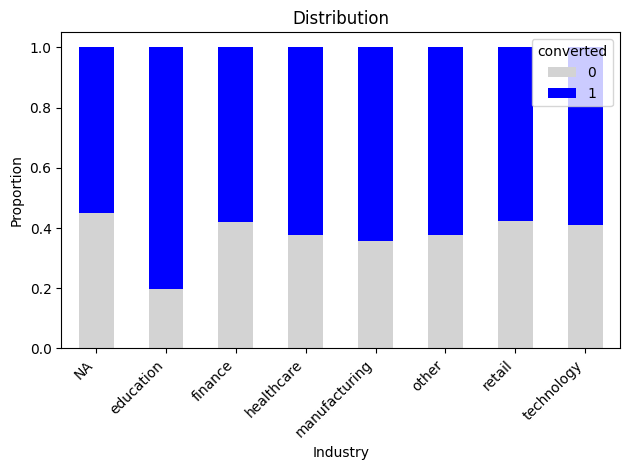

In [33]:
import matplotlib.pyplot as plt
df_temp = pd.DataFrame({"industry":df_train["industry"], "converted": y_train})
counts = df_temp.groupby("industry")["converted"].value_counts(normalize=True).unstack()
counts.plot(kind="bar", stacked=True, color=["lightgray", "blue"])
plt.title("Distribution")
plt.ylabel("Proportion")
plt.xlabel("Industry")
plt.xticks(rotation=45, ha="right")
plt.legend(title="converted")
plt.tight_layout()
plt.show()


In [34]:
counts

converted,0,1
industry,,
NA,0.448718,0.551282
education,0.198113,0.801887
finance,0.419355,0.580645
healthcare,0.376068,0.623932
manufacturing,0.357798,0.642202
other,0.376068,0.623932
retail,0.424000,0.576000
technology,0.410000,0.590000


# Q6

In [35]:
C = {}
for c in [0.01, 0.1, 1, 10, 100]:
    m = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=seed)
    m.fit(df_X_train, y_train.values)
    C[c] = accuracy_score(m.predict(df_X_val), y_val.values)
C

{0.01: 0.6996587030716723,
 0.1: 0.6996587030716723,
 1: 0.6996587030716723,
 10: 0.6996587030716723,
 100: 0.6996587030716723}

In [36]:
#???? TODO: BUG? maybe try AUC to verify